### AIDI 1002 - AI Algorithms - Final Project

### Sentiment Analysis

Michael Molnar - Durham College #100806823

## Notebook 2:  Data Preparation

#### Problem Statement:

How can we use machine learning to automatically extract the sentiment of every review, comment, blog post, or news article that mentions your business or your products?  

This project will create a model that will automatically analyze text and predict its sentiment - negative, neutral, or positive.  This solution will allow a business to automatically parse reviews and comments it receives, sorting them, and allowing for the analyis of how customers feel about the business and brand.  This analysis will allow for a company to determine how feelings towards the company change over time, or after the release of a new product or a shift in direction.  Unhappy customers can be automatically identified and prioritized.  

The proposed solution will be a classification model trained on real product reviews to identify the key words and phrases that most accurately predict the sentiment of a sample of text.

#### Focus of Notebook 2:

In this notebook I will clean and prepare the dataset for modelling.  This will take the following steps:
- Expand contractions
- Remove linebreaks
- Remove punctuation
- Convert numbers to text
- Remove punctuation produced by converting numbers to text
- Remove stop words

After the cleaning is complete I will remove any rows where the cleaning has left an empty string.  I will then re-examine the most common bigrams according to the labels.  Finally, I will combine the ratings into the three sentiment classes - positive, neutral, and negative. 

I will perform stemming in the next notebook so I can exmaine its effect on the accuracy of the models.

### Import Necessary Packages

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from num2words import num2words
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import csv
from wordcloud import WordCloud

### Loading the Data

In [52]:
df = pd.read_json('Arts_Crafts_and_Sewing_5.json.gz', orient='records', lines=True)
df.shape

(494485, 12)

In [53]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"03 29, 2016",AIE8N9U317ZBM,0449819906,{'Format:': ' Kindle Edition'},"Zelmira, Ph.D.",Contains some interesting stitches.,Four Stars,1459209600,NaN,NaN
1,5,True,"08 12, 2015",A3ECOW0TWLH9V6,0449819906,{'Format:': ' Paperback'},Dangerous when Cooking,I'm a fairly experienced knitter of the one-co...,My current favorite go-to guide for inspiration,1439337600,18,NaN
2,4,True,"04 5, 2015",A278N8QX9TY2OS,0449819906,{'Format:': ' Paperback'},Just us,Great book but the index is terrible. Had to w...,"lots of great examples, good instructions, col...",1428192000,3,NaN
3,5,True,"10 11, 2014",A123W8HIK76XCN,0449819906,{'Format:': ' Kindle Edition'},Amazon Customer,I purchased the Kindle edition which is incred...,Another little gem by Melissa Leapman,1412985600,NaN,NaN
4,5,True,"05 8, 2014",A2A6MZ2QB4AE0L,0449819906,{'Format:': ' Paperback'},Sustainability,Very well laid out and very easy to read.\n\nT...,Very comprehensive,1399507200,NaN,NaN


As mentioned in Notebook 1, I will drop all columns except for "overall" and "reviewText".

In [54]:
# Drop unnecessary columns
df.drop(columns=['verified', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'unixReviewTime', 
                 'vote', 'image', 'summary'], inplace=True)

In [55]:
# Drop rows where there is no review text
df.dropna(inplace=True)

In [56]:
# Ensure there are no missing values
df.isnull().sum()

overall       0
reviewText    0
dtype: int64

In [57]:
# Reset the Index
df.reset_index(inplace=True)

In [58]:
df

,index,overall,reviewText
0,0,4,Contains some interesting stitches.
1,1,5,I'm a fairly experienced knitter of the one-co...
2,2,4,Great book but the index is terrible. Had to w...
3,3,5,I purchased the Kindle edition which is incred...
4,4,5,Very well laid out and very easy to read.\n\nT...
...,...,...,...
494191,494480,4,What's not to love? The price. Watercolor pens...
494192,494481,5,lots of color in these markers
494193,494482,5,These are really fun to use. I love watercolor...
494194,494483,1,"While the box says vibrant colors, only a few ..."


In [59]:
# Drop the original index 
df.drop(columns='index', inplace=True)

In [60]:
df

,overall,reviewText
0,4,Contains some interesting stitches.
1,5,I'm a fairly experienced knitter of the one-co...
2,4,Great book but the index is terrible. Had to w...
3,5,I purchased the Kindle edition which is incred...
4,5,Very well laid out and very easy to read.\n\nT...
...,...,...
494191,4,What's not to love? The price. Watercolor pens...
494192,5,lots of color in these markers
494193,5,These are really fun to use. I love watercolor...
494194,1,"While the box says vibrant colors, only a few ..."


In [61]:
# Check the shape
df.shape

(494196, 2)

### Data Cleaning and Manipulating

#### Expand Contractions

As was noted in the EDA, I want to expand contractions before removing punctuations and stop words.  To do this I will make use of Python's Regular Expressions to locate contractions and make the substitutions.  Won't and can't will have to be transformed to will not and can not, respectively, first, and then all other contractions will be expanded according to the rules listed in the following function.

In [62]:
def decontract(sentence):
    sentence = re.sub(r"won\'t", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)
    
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

In [66]:
# Print a review that contains contractions, numbers, punctuation, capital letters, and stop words as a reference
df.iloc[6]['reviewText']

'This is a terrific stitch handbook (and I have a few). What sets it apart from it is competitors:\n\n1. Shows which patterns are good on both sides including pictures of both sides\n2. Pictures are in color and show good detail\n3. Better descriptions, many include how much "ease" or "give", especially useful to sock knitters.\n4. Written instructions AND charts for every pattern and a good explanation of how to use charts.\n\nI have the 365 calendar (good pictures, no charts, no description of fabric characteristics) and an aged copy of the Mon Tricot and various adds to pattern and instruction books but this is far superior to anything I have accumulated before.'

In [67]:
# Use map to apply the decontract function on all rows of the data frame
df['reviewText'] = df['reviewText'].map(lambda a: decontract(a))

In [68]:
# Print the review from above which contained contractions
df.iloc[6]['reviewText']

'This is a terrific stitch handbook (and I have a few). What sets it apart from it is competitors:\n\n1. Shows which patterns are good on both sides including pictures of both sides\n2. Pictures are in color and show good detail\n3. Better descriptions, many include how much "ease" or "give", especially useful to sock knitters.\n4. Written instructions AND charts for every pattern and a good explanation of how to use charts.\n\nI have the 365 calendar (good pictures, no charts, no description of fabric characteristics) and an aged copy of the Mon Tricot and various adds to pattern and instruction books but this is far superior to anything I have accumulated before.'

#### Remove Line Breaks

Again I will make use of Python's Regular Expressions to locate and remove all line break characters.  These I will replace with a simple space. 

In [69]:
def remove_linebreaks(input):
    text = re.compile(r'\n')
    return text.sub(r' ',input)

In [70]:
# Use map to apply the remove_linebreaks function on all rows of the data frame
df['reviewText'] = df['reviewText'].map(lambda a: remove_linebreaks(a))

In [71]:
# Print the review from above which contained linebreaks
df.iloc[6]['reviewText']

'This is a terrific stitch handbook (and I have a few). What sets it apart from it is competitors:  1. Shows which patterns are good on both sides including pictures of both sides 2. Pictures are in color and show good detail 3. Better descriptions, many include how much "ease" or "give", especially useful to sock knitters. 4. Written instructions AND charts for every pattern and a good explanation of how to use charts.  I have the 365 calendar (good pictures, no charts, no description of fabric characteristics) and an aged copy of the Mon Tricot and various adds to pattern and instruction books but this is far superior to anything I have accumulated before.'

#### Remove Punctuation

To do this I will use Python's string class to generate a list of punctuation characters.  I do this first to ensure that things such as "1." will be converted to "one" by the processing of converting numbers to text.

In [72]:
# Get a list of punctuation characters 
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [73]:
def remove_punctuation(input):
    # Check each character against the punctuation list
    no_punc = [char for char in input if char not in string.punctuation]
    # Rejoin the non-punctuations characters back into their original words 
    no_punc = ''.join(no_punc)
    return no_punc

In [74]:
# Use map to apply remove_punctuation on all rows of the data frame
df['reviewText'] = df['reviewText'].map(lambda a: remove_punctuation(a))

In [75]:
# Print the review from above which contained punctuation
df.iloc[6]['reviewText']

'This is a terrific stitch handbook and I have a few What sets it apart from it is competitors  1 Shows which patterns are good on both sides including pictures of both sides 2 Pictures are in color and show good detail 3 Better descriptions many include how much ease or give especially useful to sock knitters 4 Written instructions AND charts for every pattern and a good explanation of how to use charts  I have the 365 calendar good pictures no charts no description of fabric characteristics and an aged copy of the Mon Tricot and various adds to pattern and instruction books but this is far superior to anything I have accumulated before'

#### Convert Numbers into Text

For this I will make use of the package num2words.  This package will automatically convert digits into words.  9 becomes "nine", 42 becomes "forty-two", for example.

(https://pypi.org/project/num2words/).

In [76]:
def replace_numbers(text):
    words = []
    # split the text into words
    for word in text.split():
        # if the word is a number, convert it to text
        if word.isdigit():
            words.append(num2words(word))
        else:
            words.append(word)
    # convert the text back into a string with words separated by spaces
    return " ".join(words)

In [77]:
# Use map to apply the replace_numbers function on all rows of the data frame
df['reviewText'] = df['reviewText'].map(lambda a: replace_numbers(a))

In [78]:
# Print the review from above which contained numbers
df.iloc[6]['reviewText']

'This is a terrific stitch handbook and I have a few What sets it apart from it is competitors one Shows which patterns are good on both sides including pictures of both sides two Pictures are in color and show good detail three Better descriptions many include how much ease or give especially useful to sock knitters four Written instructions AND charts for every pattern and a good explanation of how to use charts I have the three hundred and sixty-five calendar good pictures no charts no description of fabric characteristics and an aged copy of the Mon Tricot and various adds to pattern and instruction books but this is far superior to anything I have accumulated before'

I will run remove_punctuation again because num2words adds dashes to numbers like "forty-two" and so on. 

In [79]:
df['reviewText'] = df['reviewText'].map(lambda a: remove_punctuation(a))

#### Lowercase All Text

In [80]:
# Lowercase all text
df['reviewText'] = df['reviewText'].str.lower()

In [81]:
# Print the same review
df.iloc[6]['reviewText']

'this is a terrific stitch handbook and i have a few what sets it apart from it is competitors one shows which patterns are good on both sides including pictures of both sides two pictures are in color and show good detail three better descriptions many include how much ease or give especially useful to sock knitters four written instructions and charts for every pattern and a good explanation of how to use charts i have the three hundred and sixtyfive calendar good pictures no charts no description of fabric characteristics and an aged copy of the mon tricot and various adds to pattern and instruction books but this is far superior to anything i have accumulated before'

#### Remove Stopwords

Removing stopwords is an important part of preprocessing the text data.  The reviews contain so many words such as "the" and "and" that will not be helpful for the model.  Removing these now will reduce the size of the dataset and allow the model to focus on more important words.  

For this I will make use of the Natural Language Toolkit package (https://www.nltk.org/).  The package provides a list of English stop words that I will examine and customize.

In [82]:
# Get NLTK's stopwrods list
stopwords_list = stopwords.words('english')

In [83]:
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Looking through this list I want to keep "no", "not", "only", "very".  These words may be helpful to the sentiment analysis.

In [84]:
# Take these words out of the stopwords list
stopwords_list.remove('no')
stopwords_list.remove('not')
stopwords_list.remove('very')
stopwords_list.remove('only')

In [85]:
def remove_stopwords(input):
    # Split the input, checking each word against the stop words list
    no_stop = [word for word in input.split() if word not in stopwords_list]
    # Return the cleaned text
    no_stop = ' '.join(no_stop)
    return no_stop

In [86]:
# Use map to apply the remove_stopwords function on all rows of the data frame
df['reviewText'] = df['reviewText'].map(lambda a: remove_stopwords(a))

In [87]:
# Print the review to see the output
df.iloc[6]['reviewText']

'terrific stitch handbook sets apart competitors one shows patterns good sides including pictures sides two pictures color show good detail three better descriptions many include much ease give especially useful sock knitters four written instructions charts every pattern good explanation use charts three hundred sixtyfive calendar good pictures no charts no description fabric characteristics aged copy mon tricot various adds pattern instruction books far superior anything accumulated'

That concludes the text cleaning and processing for now.  As mentioned, I will examine stemming in the next notebook.  For now I will explore again the most common unigrams and bigrams according to label.

### Checking the Most Common Unigrams and Bigrams After Cleaning

In [88]:
# Filter the dataframe into three - for ratings 5/5, 3/5, and 1/5
df_five = df[df['overall']==5]
df_three = df[df['overall']==3]
df_one = df[df['overall']==1]

This is the same function from the previous notebook.  I will use it to use Count Vectorizer to transform the text into unigrams (later bigrams), count the occurrences of each, and then create a sorted list of these.  The function returns the most common n. 

In [90]:
def n_most_common (corpus, length=1, n=None):
    vec = CountVectorizer(ngram_range=(length, length)).fit(corpus)
    words = vec.transform(corpus)
    sum_words = words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#### Five Stars

In [91]:
# Get the 30 most common words
five_star_words = n_most_common(df_five['reviewText'], n=30)
five_star_words = dict(five_star_words)

Text(0.5, 1.0, 'Top 30 Words in Five Star Reviews')

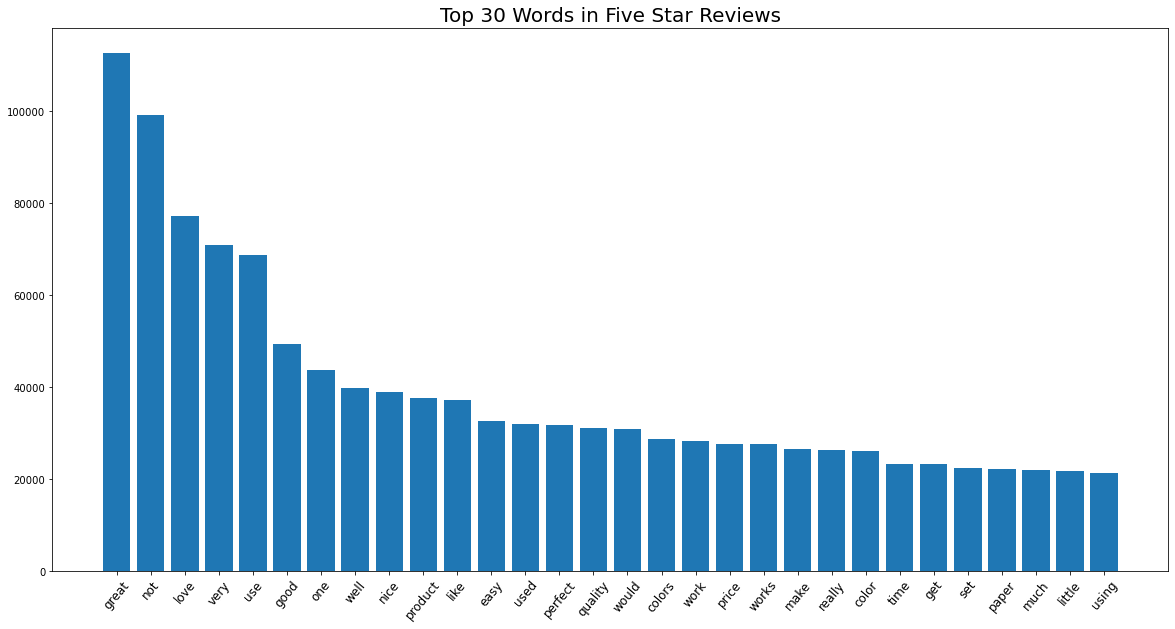

In [92]:
# Plot 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.bar(five_star_words.keys(), five_star_words.values())
plt.xticks(rotation=50,fontsize=12)
plt.title("Top 30 Words in Five Star Reviews",fontsize=20)

Because "not" is a stop word that I chose to leave in, it turns out to be the second most common word found in all of the five star reviews.  This is certainly not ideal, but I will look next at the bigrams.  Most of the other words represent positive sentiment.

In [93]:
# Get the 30 most common bigrams 
five_star_bigrams = n_most_common(df_five['reviewText'], length = 2, n=30)
five_star_bigrams = dict(five_star_bigrams)

Text(0.5, 1.0, 'Top 30 Bigrams in Five Star Reviews')

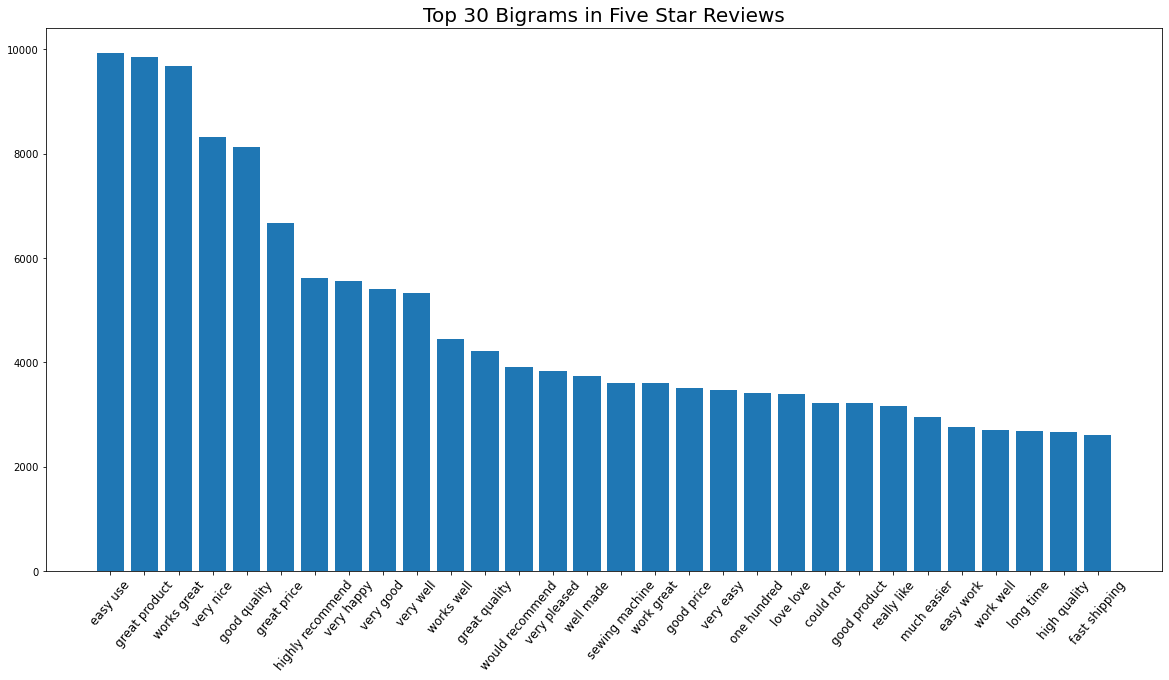

In [94]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.bar(five_star_bigrams.keys(), five_star_bigrams.values())
plt.xticks(rotation=50,fontsize=12)
plt.title("Top 30 Bigrams in Five Star Reviews",fontsize=20)

These results are much better.  Almost everything in this list is very indicative of a positive sentiment.  "Easy use", "great product", and "works nice" and the most common bigrams, but "highly recommended", "very happy", and other common phrases are also high up.  "Sewing machine" is common because the dataset is art reviews.  

In [95]:
# Generate the top 100 words and bigrams in five star reviews to create word clouds
five_star_words = n_most_common(df_five['reviewText'], n=100)
five_star_words = dict(five_star_words)
five_star_bigrams = n_most_common(df_five['reviewText'], length = 2, n=100)
five_star_bigrams = dict(five_star_bigrams)

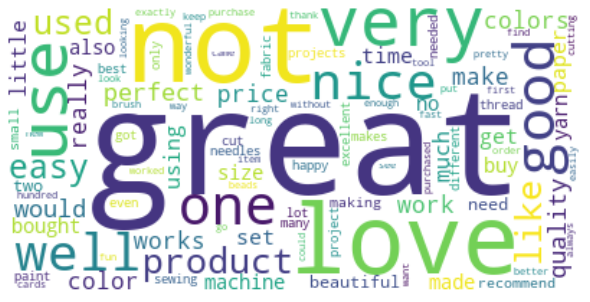

In [96]:
# Top 100 words in five star reviews
cloud = WordCloud(background_color='white').generate_from_frequencies(five_star_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

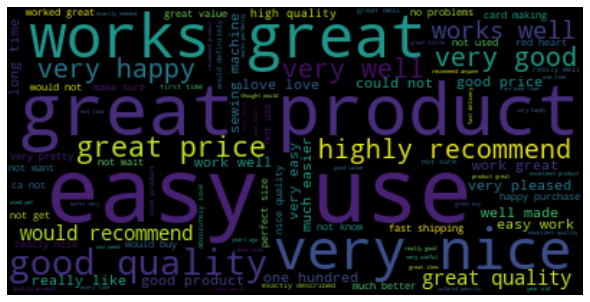

In [97]:
# Top 100 bigrams in five star reviews
cloud = WordCloud(background_color='black').generate_from_frequencies(five_star_bigrams)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#### Three Stars

In [98]:
# Get the 30 most common words
three_star_words = n_most_common(df_three['reviewText'], n=30)
three_star_words = dict(three_star_words)

Text(0.5, 1.0, 'Top 30 Words in Three Star Reviews')

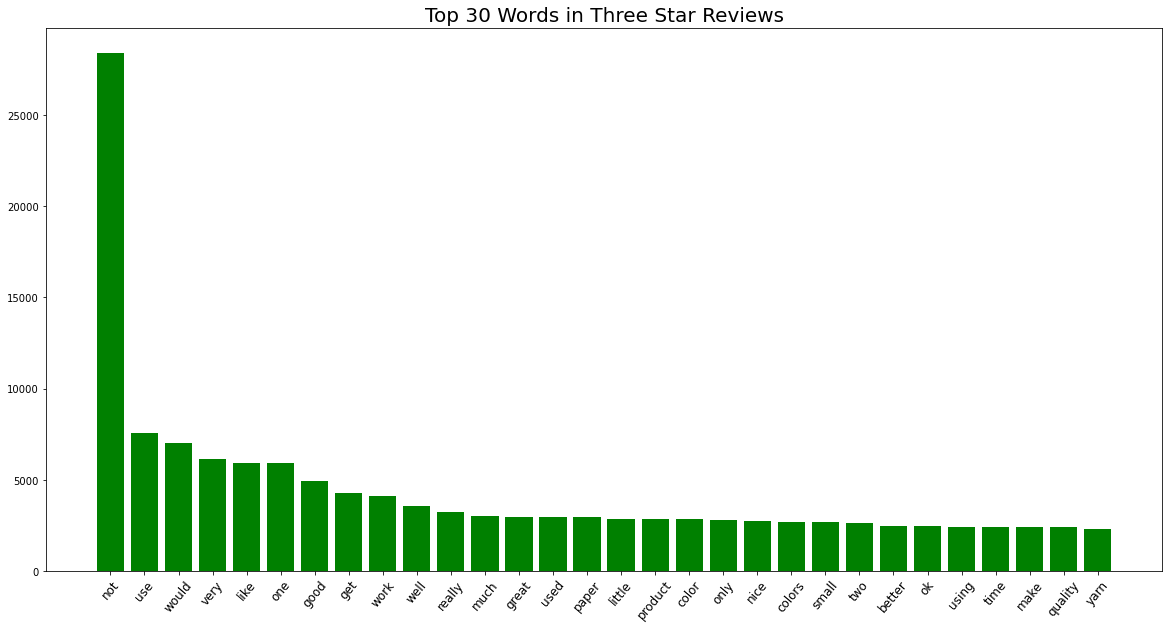

In [99]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.bar(three_star_words.keys(), three_star_words.values(), color='g')
plt.xticks(rotation=50,fontsize=12)
plt.title("Top 30 Words in Three Star Reviews",fontsize=20)

Here "not" is far and away the most common word in the 3/5 reviews.  I will now explore the bigrams.

In [100]:
# Get the 30 most common bigrams 
three_star_bigrams = n_most_common(df_three['reviewText'], length = 2, n=30)
three_star_bigrams = dict(three_star_bigrams)

Text(0.5, 1.0, 'Top 30 Bigrams in Three Star Reviews')

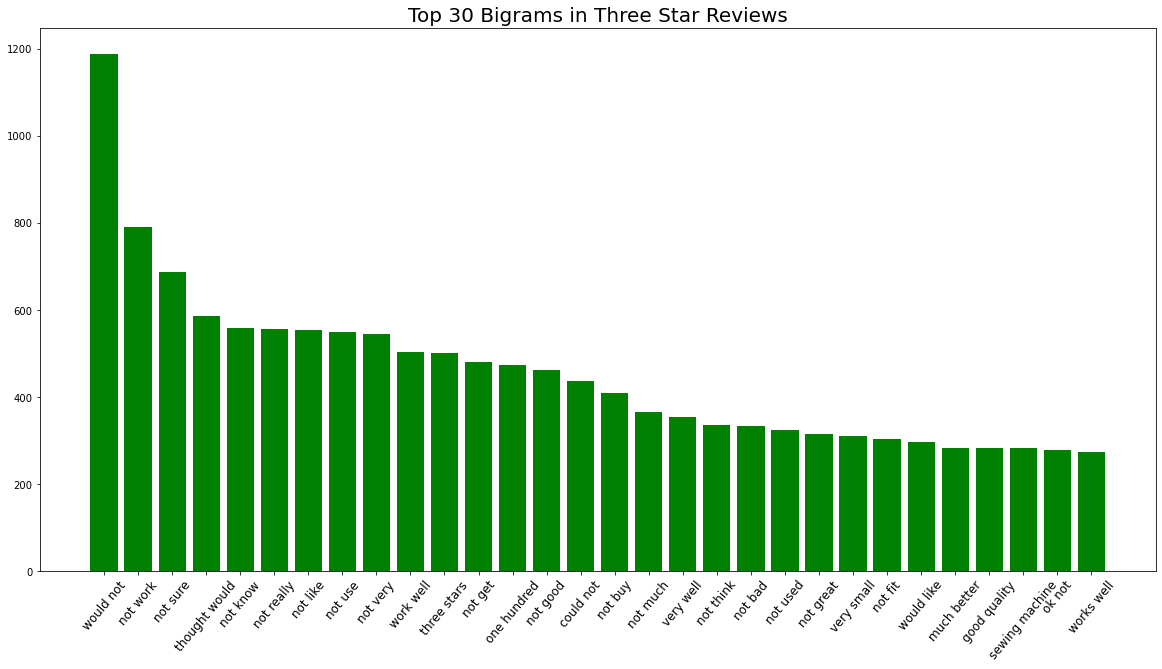

In [101]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.bar(three_star_bigrams.keys(), three_star_bigrams.values(), color='g')
plt.xticks(rotation=50,fontsize=12)
plt.title("Top 30 Bigrams in Three Star Reviews",fontsize=20)

These are neutral reveiws and these phrases seem to indicate that sentiment.  "would not", "not sure", "thought would", "not really", "not like", and others represent a feeling between positive and negative. 

In [102]:
# Generate the top 100 words and bigrams in three star reviews to create word clouds
three_star_words = n_most_common(df_three['reviewText'], n=100)
three_star_words = dict(three_star_words)
three_star_bigrams = n_most_common(df_three['reviewText'], length = 2, n=100)
three_star_bigrams = dict(three_star_bigrams)

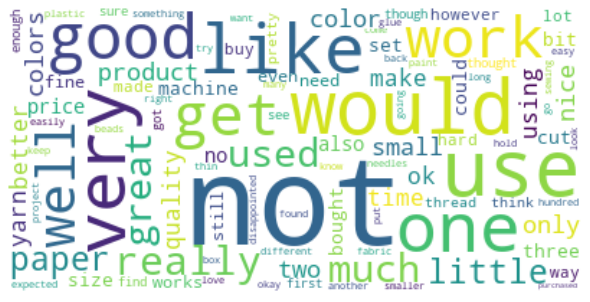

In [103]:
# The top 100 words in three star reviews 
cloud = WordCloud(background_color='white').generate_from_frequencies(three_star_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

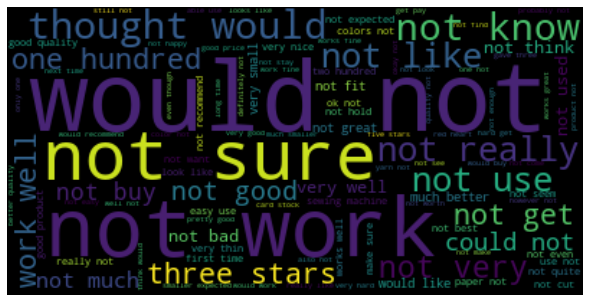

In [104]:
# The top 100 bigrams in three star reviews
cloud = WordCloud(background_color='black').generate_from_frequencies(three_star_bigrams)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#### One Star

In [105]:
# Get the 30 most common words 
one_star_words = n_most_common(df_one['reviewText'], n=30)
one_star_words = dict(one_star_words)

Text(0.5, 1.0, 'Top 30 Words in One Star Reviews')

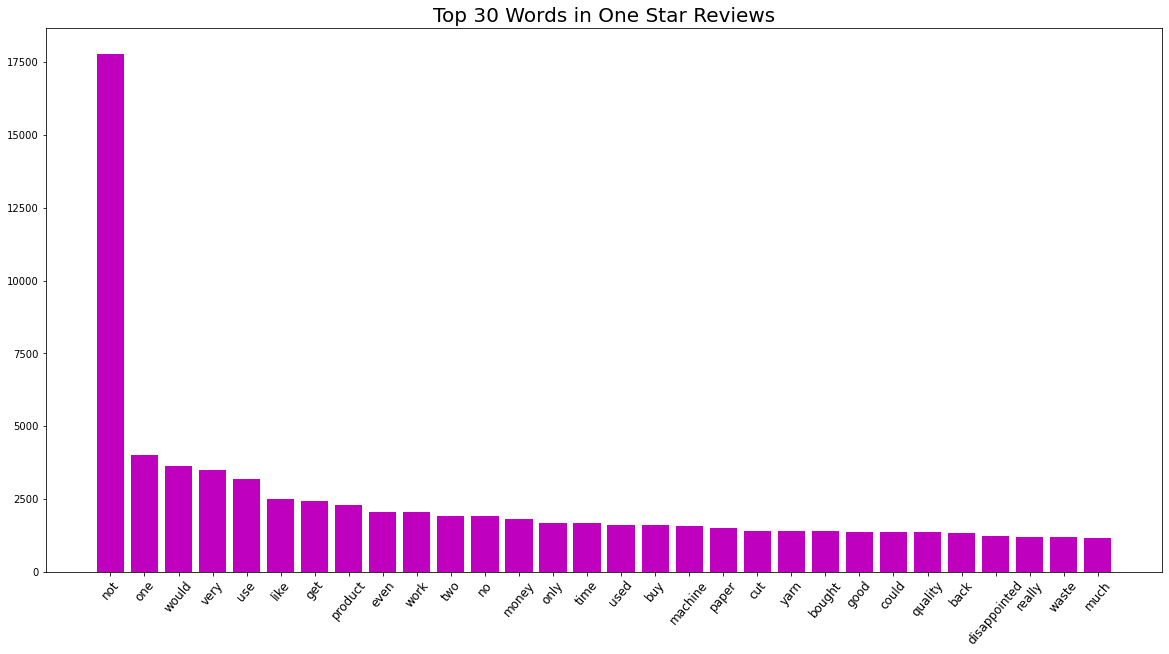

In [106]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.bar(one_star_words.keys(), one_star_words.values(), color='m')
plt.xticks(rotation=50,fontsize=12)
plt.title("Top 30 Words in One Star Reviews",fontsize=20)

"not" again is by far the most common.  Besides "disappointed" and "waste" there isn't a whole lot of negative words here.

In [107]:
# Get the top 30 bigrams 
one_star_bigrams = n_most_common(df_one['reviewText'], length = 2, n=30)
one_star_bigrams = dict(one_star_bigrams)

Text(0.5, 1.0, 'Top 30 Bigrams in One Star Reviews')

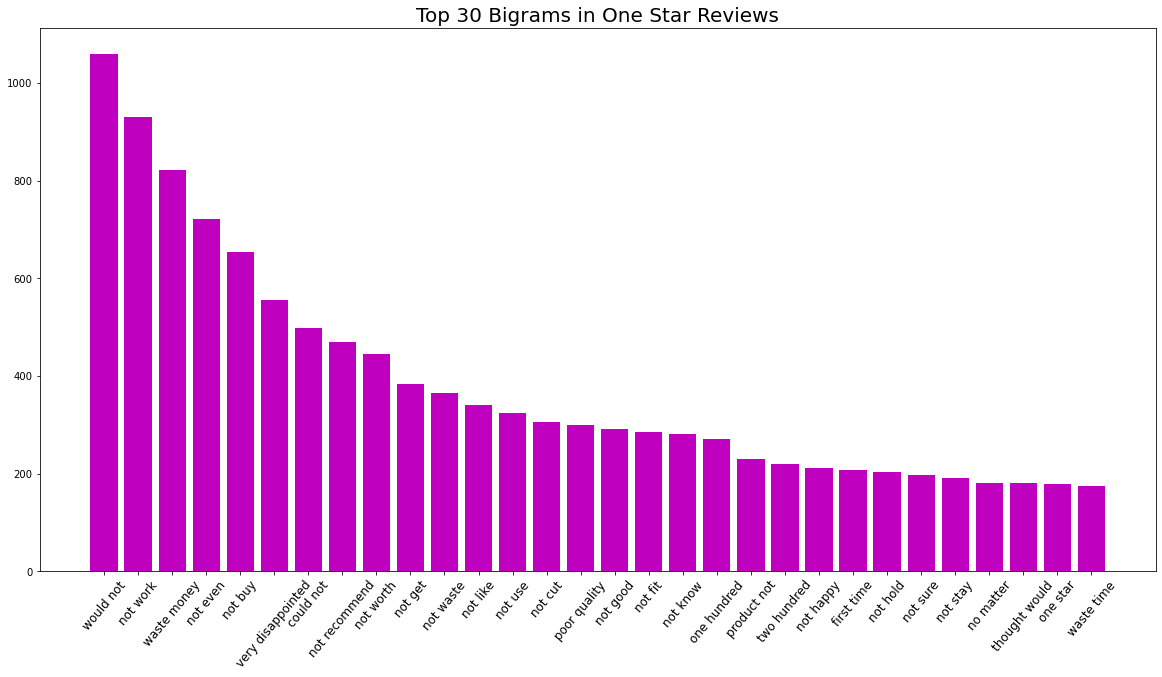

In [108]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.bar(one_star_bigrams.keys(), one_star_bigrams.values(), color='m')
plt.xticks(rotation=50,fontsize=12)
plt.title("Top 30 Bigrams in One Star Reviews",fontsize=20)

Here we see a lot of negativity.  "would not", "not work", "waste money", "very disappointed" are phrases that you'd think would be common in negative product reviews, and they are among the most commonly found in this data.

In [109]:
# Generate the top 100 words and bigrams in one star reviews to create word clouds
one_star_words = n_most_common(df_one['reviewText'], n=100)
one_star_words = dict(one_star_words)
one_star_bigrams = n_most_common(df_one['reviewText'], length = 2, n=100)
one_star_bigrams = dict(one_star_bigrams)

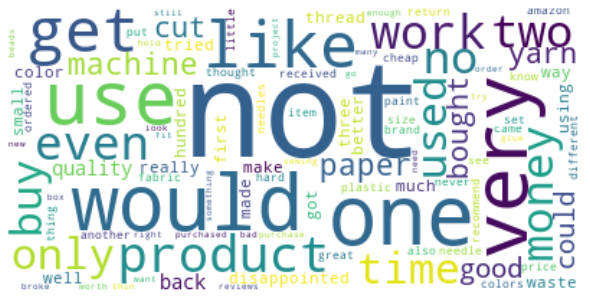

In [110]:
# Top 100 words in one star reviews
cloud = WordCloud(background_color='white').generate_from_frequencies(one_star_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

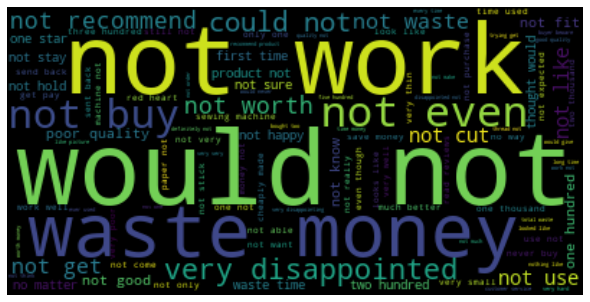

In [111]:
# Top 100 bigrams in one star reviews 
cloud = WordCloud(background_color='black').generate_from_frequencies(one_star_bigrams)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Checking for Empty Reviews

As was noted in the EDA notebook, some reviews only contained a single word, such as "A+".  With the data cleaning that has been done this review would have been removed and replaced by an empty string.  So we must once again check for missing data now that all the cleaning has been performed.

In [112]:
df[df['reviewText']=='']

,overall,reviewText
237,3,
707,4,
837,5,
1918,5,
3580,5,
...,...,...
492238,5,
492626,5,
493345,5,
493400,5,


In [113]:
# Get the index of these rows 
empty_index = df[df['reviewText']==''].index

In [114]:
empty_index

Int64Index([   237,    707,    837,   1918,   3580,   5983,   6540,   6561,
              6645,   7198,
            ...
            489208, 489936, 490185, 490550, 491554, 492238, 492626, 493345,
            493400, 493951],
           dtype='int64', length=931)

In [115]:
# Drop the rows according to this list
df.drop(df.index[empty_index], inplace=True)

In [116]:
df

,overall,reviewText
0,4,contains interesting stitches
1,5,fairly experienced knitter onecolor color bloc...
2,4,great book index terrible write high light cro...
3,5,purchased kindle edition incredibly handy part...
4,5,very well laid very easy read book also nice s...
...,...,...
494191,4,not love price watercolor pens not messy score
494192,5,lots color markers
494193,5,really fun use love watercolor not know made w...
494194,1,box says vibrant colors only pencils actually ...


### Create the Sentiment Column

I will create a new column, "sentiment", that will be the target for the learning algorithms.  I will call positive the ratings of four and five, neutral the ratings of three, and negative the ratings of one and two. 

In [117]:
df['sentiment'] = df['overall'].map(lambda x: 'negative' if x < 3 else('neutral' if x == 3 else'positive'))

In [118]:
df

,overall,reviewText,sentiment
0,4,contains interesting stitches,positive
1,5,fairly experienced knitter onecolor color bloc...,positive
2,4,great book index terrible write high light cro...,positive
3,5,purchased kindle edition incredibly handy part...,positive
4,5,very well laid very easy read book also nice s...,positive
...,...,...,...
494191,4,not love price watercolor pens not messy score,positive
494192,5,lots color markers,positive
494193,5,really fun use love watercolor not know made w...,positive
494194,1,box says vibrant colors only pencils actually ...,negative


In [119]:
# Drop the "overall" column
df.drop(columns=['overall'], inplace=True)

Text(0.5, 1.0, 'Distribution of Sentiments')

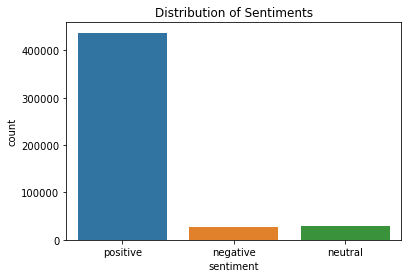

In [120]:
# Plot the class distribution
sns.countplot(x='sentiment', data=df).set_title('Distribution of Sentiments')

In [121]:
# Get the percentages of the classes
percentages = pd.Series(df['sentiment'].value_counts()/len(df.index)*100)
percentages.sort_index(inplace=True, ascending=False)
percentages

positive    88.701003
neutral      5.798911
negative     5.500086
Name: sentiment, dtype: float64

This imbalance will be addressed with undersampling once I split the data into training and testing. 

### Save the Cleaned Data

In [122]:
# Export to csv
df.to_csv('clean_review_text.csv')

I will also export the common words and bigrams list for analysis in another project.

In [123]:
with open('one_star_words.csv', 'w') as f:
    [f.write('{0},{1}\n'.format(key, value)) for key, value in one_star_words.items()]

In [124]:
with open('one_star_bigrams.csv', 'w') as f:
    [f.write('{0},{1}\n'.format(key, value)) for key, value in one_star_bigrams.items()]

In [125]:
with open('three_star_words.csv', 'w') as f:
    [f.write('{0},{1}\n'.format(key, value)) for key, value in three_star_words.items()]

In [126]:
with open('three_star_bigrams.csv', 'w') as f:
    [f.write('{0},{1}\n'.format(key, value)) for key, value in three_star_bigrams.items()]

In [127]:
with open('five_star_words.csv', 'w') as f:
    [f.write('{0},{1}\n'.format(key, value)) for key, value in five_star_words.items()]

In [128]:
with open('five_star_bigrams.csv', 'w') as f:
    [f.write('{0},{1}\n'.format(key, value)) for key, value in five_star_bigrams.items()]

### Conclusion

In this notebook I have thoroughly cleaned the text data.  Contractions have been expanded and numbers converted to text.  Punctuations, linebreaks, and stop words have all been removed and the text has been converted to lowercase.

### Next Steps:

The next notebook will deal with algorithm testing.  First, the data will be split into training and testing, and then the training set will be resampled to evenly distribute the classes.  Next, classification algorithms will be tested and tuned and one will be selected to produce the final model with.